In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, Input
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import numpy as np
import sys
from PIL import Image
import joblib
import pandas as pd
import textwrap
sys.path.append('../')

from utils.tensorflow_preprocessing import prepare_image_dataset, process_image_from_path

In [28]:
feature_extraction = tf.keras.models.load_model('../data/models/fe-cnn')
cluster = joblib.load('../data/models/cluster-kmeans.model')

In [29]:
rec_df = pd.read_csv('../data/recommend/csv/rec_df.csv')
rec_df.shape

(83598, 8)

In [30]:
class_encoder = LabelEncoder()
encoder_path = '../data/label_encoders'
class_encoder.classes_ = np.load(encoder_path + "/" + 'class_encoder.npy', allow_pickle=True)

In [31]:
style_encoder = OneHotEncoder()
encoder_path = '../data/label_encoders'
style_encoder.categories_ = np.load(encoder_path + "/" + 'style_encoder.npy', allow_pickle=True)

In [32]:
df_raw = pd.read_csv('../data/processed/csv/df.csv')
df_sample_ref_img_paths = df_raw.sample(4, random_state=21)['Path']

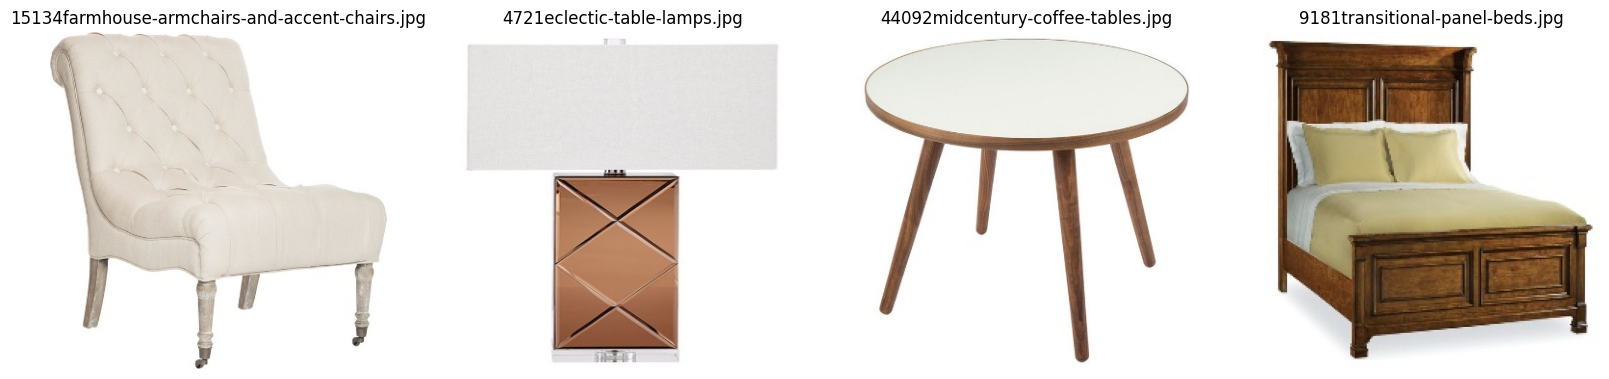

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open('../data/raw/Furniture_Data/' + f'{ref_path}') as ref:
        ax[i].imshow(ref)
        ax[i].set_title(ref_path.split('/')[-1], fontsize=12)
        ax[i].axis('off')

plt.show()

In [34]:
num_recommendations = 4   # Number of recommendations per reference image (testing)
k = int(np.sqrt(len(rec_df) / num_recommendations))
cluster.set_params(n_clusters=k)

KMeans(n_clusters=144)

In [35]:
recommendations_df = pd.read_csv('../data/recommend/csv/recommendations.csv')

In [36]:
class_labels = ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Media', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']

def classify(image_path: str, class_clf_path: str, style_clf_path: str, threshold: float = 0.5):

    image = process_image_from_path(image_path, 256, 256, for_model=True)

    class_model = models.load_model(class_clf_path)
    class_pred = class_model.predict(image)

    style_model = models.load_model(style_clf_path)
    style_pred = style_model.predict(image)

    class_pred_class_idx = tf.argmax(class_pred, axis=1).numpy()[0]
    style_pred_class_idxs = np.where(style_pred > threshold)[1]
    if style_pred_class_idxs.size == 0:
        style_pred_class_idxs = np.argsort(-style_pred, axis=1)[0, :1]
        
    class_predicted_label = class_encoder.inverse_transform([class_pred_class_idx])[0]
    style_predicted_labels = [class_labels[idx] for idx in style_pred_class_idxs]

    print(f"Class prediction: {class_predicted_label}")
    print(f"Style predictions: {style_predicted_labels}")

    return image, class_predicted_label, style_predicted_labels

In [37]:

results = []
for ref_path in df_sample_ref_img_paths:
    print(f"Reference image: {ref_path}")
    image, pred_class_label, pred_style_labels = classify('../data/raw/Furniture_Data/' + f'{ref_path}', '../data/models/task-1-CNN.keras', '../data/models/task-3-CNN.keras')

    image = np.squeeze(image)  

    ref_feature_vector = feature_extraction.predict(
            tf.expand_dims(image, axis=0),
            verbose=0
        )
        
    ref_feature_vector = ref_feature_vector.astype(np.float64)
    ref_feature_vector = ref_feature_vector.reshape(1, -1)

    # Filter recommendations based on predicted class
    filtered_recommendations = recommendations_df[
        (recommendations_df['Class'] == pred_class_label) &
        (recommendations_df['Style']).isin(pred_style_labels)
    ]

    # Cluster reference image
    cluster.fit(filtered_recommendations.drop(['Path', 'Class', 'Style'], axis='columns').values)
    ref_cluster = cluster.predict(ref_feature_vector)
    ref_cluster_indices = np.where(cluster.labels_ == ref_cluster)[0]
    recommendations = filtered_recommendations.iloc[ref_cluster_indices]

    # Calculate cosine similarities
    cosine_similarities = cosine_similarity(ref_feature_vector, recommendations.drop(['Path', 'Class', 'Style'], axis='columns'))
    sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())
    top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
    top_recommendations = recommendations.iloc[top_ref_cluster_indices]

    results.append(top_recommendations['Path'].values)

print(results)

Reference image: chairs/Farmhouse/15134farmhouse-armchairs-and-accent-chairs.jpg
1/1 [==============================] - 0s 150ms/step
Class prediction: chairs
Style predictions: ['Transitional']
Reference image: lamps/Eclectic/4721eclectic-table-lamps.jpg
1/1 [==============================] - 0s 144ms/step
Class prediction: lamps
Style predictions: ['Contemporary']
Reference image: tables/Midcentury/44092midcentury-coffee-tables.jpg
1/1 [==============================] - 0s 135ms/step
Class prediction: tables
Style predictions: ['Midcentury']
Reference image: beds/Transitional/9181transitional-panel-beds.jpg
1/1 [==============================] - 0s 138ms/step
Class prediction: beds
Style predictions: ['Traditional']
[array(['chairs/Transitional/23887transitional-dining-chairs.jpg',
       'chairs/Transitional/13937transitional-dining-chairs.jpg',
       'chairs/Transitional/14270transitional-dining-chairs.jpg',
       'chairs/Transitional/24623transitional-armchairs-and-accent-chairs

1/1 [==============================] - 0s 151ms/step
Class prediction: chairs
Style predictions: ['Transitional']
1/1 [==============================] - 0s 136ms/step
Class prediction: lamps
Style predictions: ['Contemporary']
1/1 [==============================] - 0s 150ms/step
Class prediction: tables
Style predictions: ['Midcentury']
1/1 [==============================] - 0s 173ms/step
Class prediction: beds
Style predictions: ['Traditional']


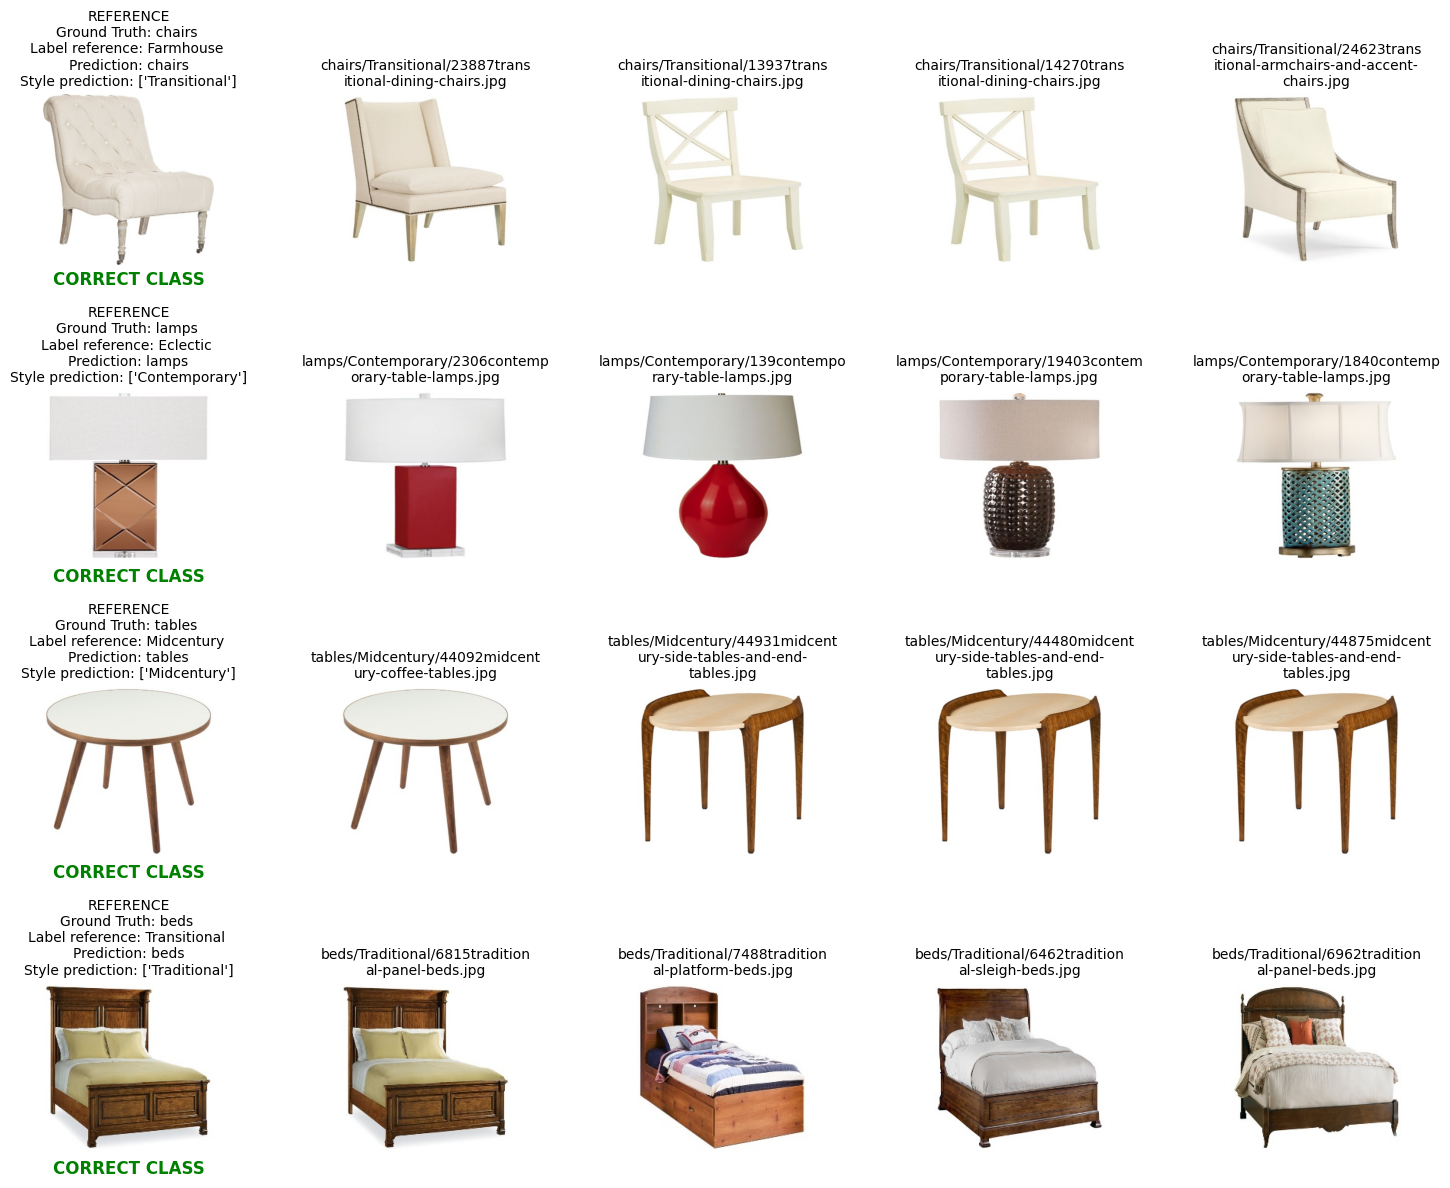

In [38]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open('../data/raw/Furniture_Data/' + f'{ref_path}') as ref:
        true_label = ref_path.split('/')[0]
        style_label = ref_path.split('/')[1]
        _, predicted_label, pred_style_labels = classify('../data/raw/Furniture_Data/' + f'{ref_path}', '../data/models/task-1-CNN.keras', '../data/models/task-3-CNN.keras')

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label} \n'
            f'Label reference: {style_label} \n'
            f'Prediction: {predicted_label}\n'
            f'Style prediction: {pred_style_labels}',
            fontsize=10
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open('../data/raw/Furniture_Data/' + f'{rec_path}') as rec:
            ax[i][j].imshow(rec)
            wrapped_rec_path = textwrap.fill(rec_path, 30)  # wraps the text if it's longer than 30 characters
            ax[i][j].set_title(wrapped_rec_path, fontsize=10)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()
